# Pruebas de hipótesis

Uno de los pasos en **ESDA** es el probar si los datos geográficos cuentan con algún tipo de **estructura espacial**. Probar esto es importante ya que si en efecto existe estructura espacial en los datos, entonces se debe incorporar esta misma estructura en todo el análisis.

La parte teórica de este _notebook_ se complementó con diversas secciones del curso [Introduction to Spatial Data Science](https://www.youtube.com/playlist?list=PLzREt6r1NenmFyTw8v2JZpEE4PZGNi5Ht) de la Universidad de Chicago, y se estructura en los siguientes apartados:

* [Aleatoriedad espacial](#Aleatoriedad-espacial)
* [Bases de pruebas de hipótesis](#Bases-de-pruebas-de-hipótesis)
* [Autocorrelación espacial](#Autocorrelación-espacial)
* [Estadísticos para autocorrelación espacial](#Estadísticos-para-autocorrelación-espacial)
    * [Construcción del estadístico](#Construcción-del-estadístico)
    * [Pesos espaciales](#Pesos-espaciales)
    * [Criterios de contigüidad](#Criterios-de-contigüidad)
    * [Estandarización de pesos](#Estandarización-de-pesos)
* [Autocorrelación espacial global](#Autocorrelación-espacial-global)
    * [Estadístico Moran's I](#Estadístico-Moran's-I)
    * [Rezago espacial](#Rezago-espacial)
    * [Interpretación](#Interpretación)
    * [Significancia estadística](#Significancia-estadística)
* [Autocorrelación espacial local](#Autocorrelación-espacial-local)

## Aleatoriedad espacial

Aleatoriedad espacial, también conocidad como _Spatial Randomness_ (**S.R**), es la ausencia de cualquier tipo de patrón espacial en los datos. En términos de análisis es de interés encontrar evidencia en contra de S.R, misma que debe satisfacer dos condiciones:

* Las observaciones son equiprobables de ocurrir en cualquier ubicación en el espacio.
* El valor de una observación no depende del valor de sus vecinos.

La ubicación de las observaciones puede ser alterada sin afectar la información contenida en los datos bajo S.R, esto se puede hacer mediante procesos de permutación de los valores. 

## Bases de pruebas de hipótesis

Dado que es de interés encontrar evidencia en contra de S.R, entonces nos podemos apalancar de la [1° ley geográfica de Tobler](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography) para el planteamiento de pruebas de hipótesis, misma que plantea que en un espacio geográfico "_Todo está relacionado con todo, pero las cosas más cercanas aún más_". Bajo esta ley se pueden extraer dos conclusiones importantes:

1) Hay estructura de dependencia espacial.
2) Existe decaemiento en la correlación de las cosas con la distancia, es decir, observaciones muy separadas estarán menos asociadas.

Lo anterior lleva al planteamiento de **pruebas de hipótesis** apalancadas del concepto de **autocorrelación espacial**, de tal modo que:

* $H_0$: Los datos se distribuyen bajo aleatoriedad espacial.
* $H_1$: Los datos presentan estructura espacial.

## Autocorrelación espacial

La autocorrelación espacial busca medir la **variación de una misma variable en ubicaciones distintas**, y puede tomar valores tanto positivos como negativos, lo cual lleva a la interpretación de tres posibles casos:

1) Autocorrelación **positiva**
> Se da cuando las observaciones de una vecindad tienen valores similares, sean negativos (_coldSpot_) o positivos (_hotSpot_), con mayor frecuencia que en S.R, lo cual resulta en la presencia de **segmentos geográficos** (**_clusters_**).

2) Autocorrelación **nula**
> No existe autocorrelación en los datos por lo que hay **aleatoriedad espacial**.

3) Autocorrelación **negativa**
> Se da cuando las observaciones de una vecindad tienen **valores alternantes** con mayor frecuencia que en S.R, lo cual resulta en estructuras tipo tablero de Ajedrez.

Para ilustrarlo, considera la siguiente figura:

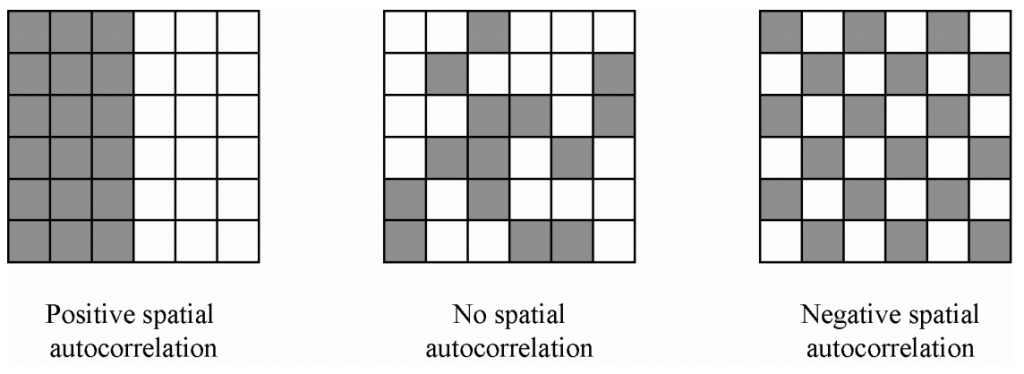

Para el desarrollo de los ejemplos que ilustran estos conceptos, se retomará el caso de los datos de _Airbnb_ para el estado de Nueva York.

Carga de librerías:

In [37]:
# Gestión del sistema
import os
import warnings
os.environ['USE_PYGEOS'] = '0'
#warnings.filterwarnings(action='ignore', module='seaborn\..*')

# Librerías de análisis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.random import seed

# Librerías de análisis espacial
import pysal
import splot
import contextily
import geopandas as gpd
import splot.esda

from pysal.viz import splot
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import lisa_cluster, plot_local_autocorrelation

Los datos serán los mismos que los que se construyeron en la sección [Mapas sin outliers](../Chapter05/data_visualization.ipynb#Mapas-sin-outliers) del capítulo anterior.

Primero los datos de _airbnb_:

In [3]:
# Rutas relativas a archivos de datos
ROOT = os.path.dirname(os.getcwd())
data_path = os.path.join(ROOT, 'data', 'Data pt1')

# Datos de airbnb
listings = pd.read_csv(
    os.path.join(data_path,'listings.csv.gz')
    ,compression='gzip'
    ,low_memory=False)

# Subconjunto de variables
listings_sub = (
    # Filtro inicial de variables
    listings.filter(
        items=['id','property_type','neighbourhood_cleansed'
               ,'neighbourhood_group_cleansed','accommodates'
               ,'bedrooms','price','latitude','longitude'])
    # Limpieza inicial
    .assign(
        price = lambda _df: _df.price.replace("[$,]", "", regex=True).astype(float)
        ,bedrooms = lambda _df: _df.bedrooms.fillna(value=0)))

# Converción a geoDataFrame
listings_sub_gpd = gpd.GeoDataFrame(
    data=listings_sub
    ,geometry=gpd.points_from_xy(
        x=listings_sub.longitude
        ,y=listings_sub.latitude
        ,crs=4326))

Después los datos del censo de Nueva York:

In [4]:
# Carga de regiones estadísticas de todo Nueva York
NY_tracts_path = "https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_36_tract.zip"
NY_Tracts = gpd.read_file(filename=NY_tracts_path)
NY_Tracts = NY_Tracts.to_crs(crs=4326)

Seguido de las _Core-Based Statistical Areas_ (**CBSA**) y agregación de los datos por las mismas:

In [5]:
# Carga de CBSA de todo Estados Unidos
cbsa_path = 'https://www2.census.gov/geo/tiger/TIGER2021/CBSA/tl_2021_us_cbsa.zip'
cbsas = gpd.read_file(filename=cbsa_path)

# Subconjunto de una única CBSA de Nueva York
NY_cbsa = cbsas[cbsas['GEOID']=='35620']

# Intersección espacial para CBSA de Nueva York
mask = NY_Tracts.intersects(other=NY_cbsa.loc[620,'geometry'])
NY_Tracts_subset = NY_Tracts.loc[mask]

# Unir datos de airbnb a conjunto de regiones estadísticas
NY_Tracts_sj = gpd.sjoin(
    left_df=NY_Tracts_subset
    ,right_df=listings_sub_gpd
    ,how='left'
    ,predicate='contains')

# Filtrar variables de interés y agregar media por CBSA
NY_Tracts_sj = NY_Tracts_sj[['GEOID','price','accommodates','bedrooms','geometry']]
NY_Tracts_Agg = NY_Tracts_sj.dissolve(by='GEOID', aggfunc='mean')

Finalmente, la limpieza de _outliers_ de la base

In [6]:
# Media y desv. estándar para eliminar outliers
mean_price = NY_Tracts_Agg['price'].dropna().mean()
stdev = NY_Tracts_Agg['price'].dropna().std()

# Filtrar registros a menos de una std
NY_Tracts_Agg_filtered = NY_Tracts_Agg[NY_Tracts_Agg['price'] < mean_price + stdev]
NY_Tracts_Agg_filtered.reset_index(inplace=True)
NY_Tracts_Agg_filtered.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2085 entries, 0 to 2084
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   GEOID         2085 non-null   object  
 1   geometry      2085 non-null   geometry
 2   price         2085 non-null   float64 
 3   accommodates  2085 non-null   float64 
 4   bedrooms      2085 non-null   float64 
dtypes: float64(3), geometry(1), object(1)
memory usage: 81.6+ KB


## Estadísticos para autocorrelación espacial

Recordando que un **estadístico** es cualquier valor que resume alguna característica de una distribución de referencia ($H_0$), entonces un **estadístico de prueba** es aquel que se calcula de los datos y se compara con esa misma distribución buscando responder a la pregunta:

> ¿Qué tan probable es el estadístico de prueba si éste hubiera ocurrido bajo la $H_0$?

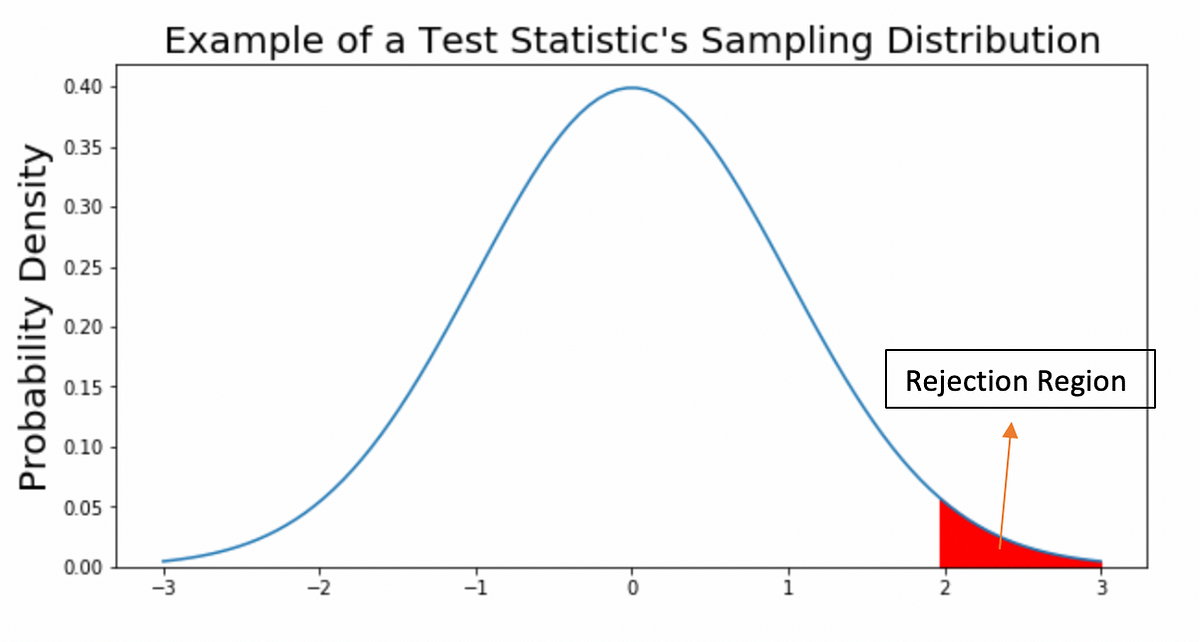

Éste entonces acepta o rechaza la $H_0$ en función de si la probabilidad de observar esos datos supera o no la región de rechazo en la distribución de referencia.

### Construcción del estadístico

Para construir un estadístico de prueba en un contexto espacial es necesario que éste capture tanto la **similitud de atributos** como la **similitud de ubicación**, y además debe ser construido a partir de los mismos datos.

* Similitud de **atributos**: $f(x_i, x_j)$
> Resume la similitud de diferentes observaciones de una misma variable $x$ en las diferentes ubicaciones $i$, $j$, de modo que es una función $f(x_i,x_j)$.

* Similitud de **ubicación**: $w_{ij}$
> Formaliza la noción de un vecino a través de los **pesos espaciales** $w_{ij}$ que se almacenan en la matriz de pesos espaciales $W$ a través de algún tipo de interacción.

Con estas dos partes se puede construir un estadístico $z$ que sume a lo largo de todos los pares de observaciones $(i, j)$ el producto de la similitud de atributos con la similitud de ubicación, de modo que:

$$z = \sum_{ij}f(x_i,x_j)\cdot w_{ij}$$

### Pesos espaciales

Es **sumamente importante** entender el siguiente concepto:

> La autocorrelación espacial se basa fundamentalmente en definir la **interacción entre un par de observaciones** para todos los posibles pares de observaciones de un espacio geográfico. En ese sentido, el principal problema es que para $n$ observaciones se tendría que determinar la interacción de aproximadamente $n\cdot(\frac{n-1}{2})$ interacciones por pares.
>
> Lo anterior es algo que no será posible erradicar debido a un **problema incidental de pramátros**, es decir, el número de parámetros aumenta a medida que aumenta el número de observaciones. Para interacciones espaciales, el número de parámetros crece en $n^2$.

La solución radica entonces en imponer algún tipo de estructura a los datos para limitar el número de parámetros por estimar, es aquí en donde los [**pesos espaciales**](https://www.youtube.com/watch?v=yjFNuyfskaQ) desempeñan un papel esencial al formalizar la noción de vecinos. Fundamentalmente, los pesos espaciales están diseñados para **excluir algunas interacciones** al limitar el número de vecinos de una observación, por ejemplo, considerando aquellas ubicaciones con las que comparte una frontera.

Entonces la **escala de interacción** entre pares de observaciones queda definida por un efecto combinado entre el **coeficiente de correlación** asociado a la similitud de atributos, y el **peso** asociado a la similitud de ubicación.

Con la definición de los pesos espaciales, el siguiente paso sería construir la **Matriz de Pesos Espaciales** ($W$) en función de algún tipo de criterio, que es una matríz de $nxn$ que almacena a cada peso $w_{ij}$ y que cumple con las siguientes características:

* $w_{ij}\neq 0$ para vecinos.
* $w_{ij} = 0$ implica que $i$ y $j$ no son vecinos.
* $w_{ii} = 0$ dado que no hay similitud entre una observación con ella misma.

Esto provoca que $W$ sea una matriz con un gran número de elementos en $0$, mismos que anulan el efecto de la interacción entre observaciones y que por tanto reducen el número de parámetros por calcular.

### Criterios de contigüidad

Como se mencionó, la matriz de pesos se debe definir bajo algún criterio determinado, mismos que son conocidos como **criterios de contigüidad**. Escencialmente existen dos clasificaciones para estos criterios:

#### Criterios binarios

Se trata del tipo de criterio más simple, se asignan **pesos booleanos** a las observaciones que comparten algún tipo de frontera física. El hecho de requerir de algún tipo de frontera implica que este tipo de criterio sea utilizado en **polígonos**.

* $w_{ij}=0$: No se comparte frontera física
* $w_{ij}=1$: Se comparte alguna frontera

El siguiente ejemplo ilustra la idea detrás de un criterio binario de contigüidad:

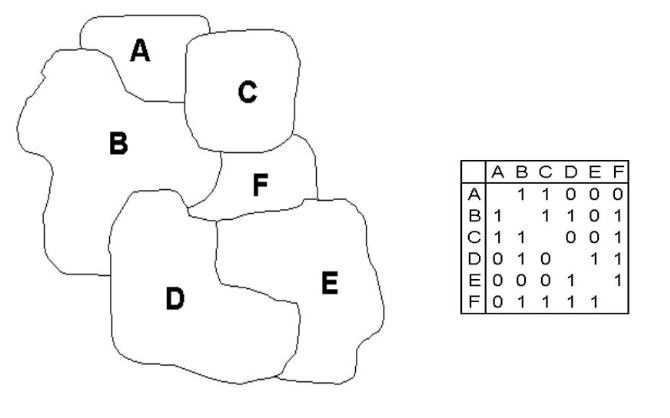

Sin embargo, al construir la matriz de pesos utilizando criterios binarios se tienen complicaciones que resultan en dos enfoques a la hora de definir el qué es una frontera:

* Matriz de **Contigüidad de Torre**:
> Para la definición de contigüidad considera **únicamente fronteras completas**. Su nombre es alusivo al movimiento de una torre en ajedrez.

* Matriz de **Contigüidad de Reina**:
> Para la definición de contigüidad considera tanto **fronteras completas** como **esquinas**. Su nombre es alusivo al movimiento de una reina en ajedrez.

Para ilustrarlo mejor, considera la siguiente figura:

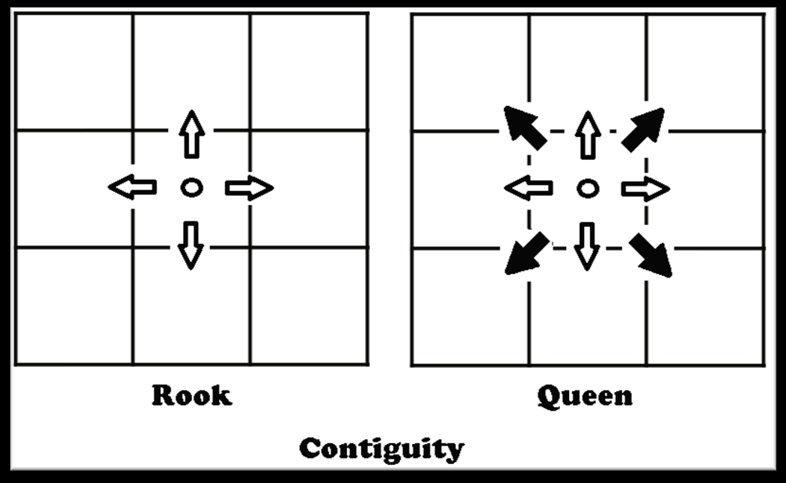

#### Criterios basados en distancia

En general están basados en cualquier tipo de función de distancia lo cual implica que su aplicación sea en **puntos**, por ejemplo, el centroide de polígonos. Sin embargo, dado que una de las implicaciones de la _1° Ley de Tobler_ es el **decaemiento por distancia** en la correlación de las cosas, entonces no se podría utilizar directamente la distancia sino su recíproco.

Algunos de los criterios de distancia más comunes en la práctica son:

* **Radio de cobertura**:
> Se debe definir un _buffer_ de cobertura basada en una distancia de modo que aquellas observaciones dentro de cobertura son vecinas y aquellas fuera de cobertura no:
>
> * $w_{ij} = 0$ si $d_{ij} > r$
> * $w_{ij} \neq 0$ si $d_{ij} \leq r$
>
> Sin embargo, existe un **riesgo** en la definición del radio de cobertura para aquellos casos en que las regiones geográficas tienen tamaños muy diferentes entre sí, y es que regiones pequeñas tengan demasiados vecinos, y regiones grandes no tengan ningún vecino, por ejemplo:
>
> 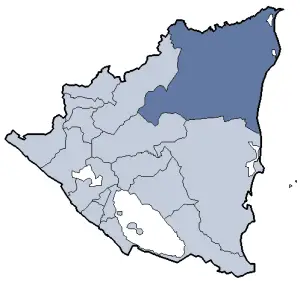

* Vecinos más cercanos (**kNN**):
> Surge como una solución al problema del criterio anterior, y considera a los $k$ vecinos más cercanos a una observación de interés independientemente de la distancia entre ellos. Esto resulta en el **mismo número de vecinos** para todas las observaciones.

### Estandarización de pesos

Otro concepto importante en la definición de la matriz de pesos espaciales es la **estandarización por renglón** de los pesos. Esto es que para cada renglón de la matriz de pesos se hace un reescalamiento de sus valores:

$$w^*_{ij} = \frac{w_{ij}}{\sum_j w_{ij}}$$

De modo que sumen $1$, es decir, $\sum_j w^*_{ij} = 1$

Lo anterior es importante debido a que:

* Se restringe el espacio parametral de los pesos.
* Para todos los vecinos de una observación sabemos que la suma de pesos siempre será uno.
* Vuelve el análisis comparable de una observación a otra.
* Permite hacer un cálculo posterior llamado **rezago espacial**, referente al promedio de los vecinos.

Como referencia considera el siguiente ejemplo de una matriz con su respectiva estandarización por renglón:

$$A = \begin{pmatrix}
1 & 0 & 0 & 0\\
1 & 1 & 0 & 0\\
1 & 1 & 1 & 0\\
1 & 1 & 1 & 1
\end{pmatrix} \rightarrow 
A^* = \begin{pmatrix}
1 & 0 & 0 & 0\\
1/2 & 1/2 & 0 & 0\\
1/3 & 1/3 & 1/3 & 0\\
1/4 & 1/4 & 1/4 & 1/4
\end{pmatrix}$$

Toda la teoría revisada hasta este punto se traduce a dos comandos del módulo `pysal.lib`, librería para la cual se debe estar familiarizado con la [documentación](https://pysal.org/pysal/api.html).

**Paso 1**: Construir la matriz de pesos bajo algún criterio de contigüidad.

In [7]:
# Matriz de pesos bajo criterio de reinas
w = weights.Queen.from_dataframe(
    df=NY_Tracts_Agg_filtered
    ,silence_warnings=True)

# Vista previa de primera observación
print(f"""N. Vecinos: {w.cardinalities[0]}
ID's: {list(w[0].keys())}
Pesos: {list(w[0].values())}""")

N. Vecinos: 5
ID's: [1, 2, 6, 8, 1886]
Pesos: [1.0, 1.0, 1.0, 1.0, 1.0]


Lo cual quiere decir que la observación $0$ tiene en total $5$ vecinos, y son las observaciones $(1, 2, 6, 8, 1886)$.

**Paso 2**: Estandarización por renglón de los pesos.

In [8]:
# Estandarización por renglón
w.set_transform(value='R')

# Vista previa de primera observación
print(f"""N. Vecinos: {w.cardinalities[0]}
ID's: {list(w[0].keys())}
Pesos: {list(w[0].values())}""")

N. Vecinos: 5
ID's: [1, 2, 6, 8, 1886]
Pesos: [0.2, 0.2, 0.2, 0.2, 0.2]


Una vez que se ha construido la matriz de pesos, se puede inspeccionar el **histograma de conectividad** que no es más que el histograma del número de vecinos por observación (**cardinalidad**).

Aspectos que debes atender con detenimiento en un histograma de conectividad:

* Observaciones aisladas (sin vecinos).
* Cardinalidades inusualmente altas, que son un reflejo de una $W$ que no está desempeñándose correctamente.
* Bimodalidad en la distribución.

Total de elementos
no nulos en matriz de pesos:
12,266 de 4,347,225


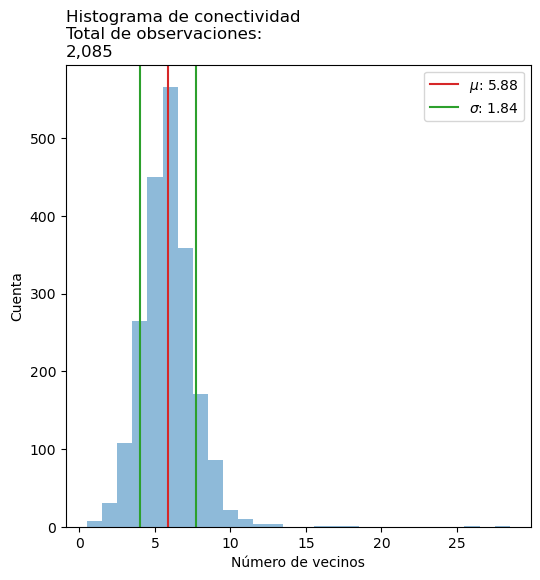

In [9]:
print(f'Total de elementos\nno nulos en matriz de pesos:\n{w.sparse.nnz:,} de {w.n**2:,}')

# Especificaciones de figura
fig, ax = plt.subplots(figsize=(6,6))

# Elementos de visualización
ax.bar(
    x=np.array(w.histogram)[:,0]
    ,height=np.array(w.histogram)[:,1]
    ,width=1
    ,color='tab:blue'
    ,alpha=0.5)
ax.axvline(
    x=w.mean_neighbors
    ,color='tab:red'
    ,label=fr'$\mu$: {w.mean_neighbors:.2f}')
ax.axvline(
    x=w.mean_neighbors + w.sd
    ,color='tab:green'
    ,label=fr'$\sigma$: {w.sd:.2f}')
ax.axvline(
    x=w.mean_neighbors - w.sd
    ,color='tab:green')

# Anotaciones y estilo
ax.set_title(f'Histograma de conectividad\nTotal de observaciones:\n{w.n:,}', loc='left')
ax.set(
    xlabel='Número de vecinos'
    ,ylabel='Cuenta')
ax.legend()

plt.show()

## Autocorrelación espacial global

Llegado a este punto, la **autocorrelación espacial global** es el primer paso para determinar autocorrelación espacial en un **estadístico global** que resume tanto similitud de atributos como de ubicación. Sin embargo, tiene algunas limitantes para lo cual se tiene que hacer la siguiente distinción:

> La autocorrelación espacial global es una prueba que determina **si hay evidencia de _clusters_** (estructura espacial) en los datos, descartando que estos hayan sido generados bajo un proceso de aleatoriedad espacial. La autocorrelación espacial global por sí misma **no identifica los _clusters_** ni su ubicación.

### Estadístico Moran's I

En la sección [Estadísticos para autocorrelación espacial](#Estadísticos-para-autocorrelación-espacial) se mencionó que la construcción de un estadístico debe ser de la forma $z=\sum_{ij}f(x_i,x_j)\cdot w_{ij}$. Para este fin, existen una gran variedad de estadísticos siendo el [_Moran's I_](https://en.wikipedia.org/wiki/Moran%27s_I) el más común de ellos, y su formulación típica es la siguiente:

$$(1):\ I = \frac{N}{S_0}\frac{\sum_{i=1}^N\sum_{j=1}^N w_{ij}(x_i-\bar x)(x_j-\bar x)}{\sum_{i=1}^N (x_i-\bar x)^2}$$

En donde los términos $(x_i-\bar x)$, $(x_j-\bar x)$ son la desviación de una observación con respecto a la media de modo que queden centradas en $0$ en el comportamiento general, y en lo subsecuente se reemplazarán por $z_i$, $z_j$ respectivamente, y los términos:

* $N$: Número de observaciones
* $S_0$: Suma de todos los pesos espaciales $\sum_{ij}w_{ij}$

Para efectos de interpretación se reformula el estadístico de la siguiente manera:

$$(2):\ I = \left(\frac{\sum_{ij}w_{ij}(z_i\cdot z_j)}{S_0}\right) \left(\frac{\sum_{i} z_i^2}{N}\right)^{-1}$$

**Observaciones**:

* El término $\frac{1}{N}\sum_i z_i^2$ es una estimación de la [varianza](https://economipedia.com/definiciones/varianza.html).
* Si los pesos fueron previamente **estandarizados por fila** entonces la suma de los pesos espaciales $S_0=\sum_i\sum_j w_{ij}^*=N$, con lo cual se puede ver que el término $\frac{1}{S_0}(z_i\cdot z_j)$ es análogo a la [correlación de Pearson](https://www.questionpro.com/blog/es/coeficiente-de-correlacion-de-pearson/). Esta similitud es una de las razones por las que es el estadístico más común.
* De igual forma, si los pesos fueron estandarizados por fila entonces el estadístico se simplifica a la formulación:

$$(3):\ I = \frac{\sum_{ij}w_{ij}(z_i\cdot z_j)}{\sum_{i} z_i^2}$$

### Rezago espacial

Con la formulación $(3)$ de _Moran's I_, que considera que los pesos fueron estandarizados por fila, se puede visualizar de forma más directa una nueva forma de representar el estadístico:

$$(4):\ I = \frac{\sum_iz_i \left(\sum_j w_{ij}\cdot z_j \right)}{\sum_i z_i^2}$$

Bajo esta nueva formulación, el término $\sum_j w_{ij}\cdot z_j$ se conoce como el **rezago espacial** de la observación $i$, que es un promedio ponderado de la variable de interés $z$ en los vecinos de la observación $i$. Haciendo un cambio de variable $l_i = \sum_j w_{ij}\cdot z_j$, entonces:

$$I = \frac{\sum_iz_i\cdot l_i}{\sum_i z_i^2}$$

Lo cual hace evidente que _Moran's I_ es un [coeficiente de regresión ](https://en.wikipedia.org/wiki/Simple_linear_regression) para la línea de ajuste entre la variable de interés $z$ y su rezago espacial $l$, por tanto, el estadístico $I$ es la pendiente de la línea de ajuste.

### Interpretación

Sabiendo que el estadístico _Moran's I_ es la pendiente de la línea de ajuste entre la variable de interés y su rezago espacial, entonces la interpretación del estadístico depende paralelamente tanto de la **señal** como de la **significancia**, y la primera cosa que se debe asegurar a la hora de interpretarlo es que sea **estadísticamente significativo**, de otro modo, la señal por sí misma no dice absolutamente nada. Este proceso se describe con mayor detenimiento más adelante. 

Dicho eso, una vez asegurada la significancia, entonces se interpreta de la siguiente manera:

* Si la señal es positiva, entonces hay evidencia de **_clusters_**. Recuerda que estos son referentes a **valores similares en una vecindad** y no necesariamente tienen que ser positivos o negativos.
* Si la señal es negativa, entonces hay evidencia de **valores alternantes**.

Para ilustrarlo, se continúa con el ejemplo de los datos de _Airbnb_ con la siguiente secuencia de transformaciones:

**Paso 1**: Calcular el rezago de las observaciones para la variable `price` y centrar ambas variables con respecto a sus medias.

In [10]:
# Calcular columnas de rezago
NY_Tracts_Agg_filtered = (
    NY_Tracts_Agg_filtered
    .assign(
        # Rezago espacial de la variable de interés
        price_lag = lambda _df: weights.spatial_lag.lag_spatial(w=w, y=_df.price)
        # Centrar a la media y escalar a 2 std
        ,price_scaled = lambda _df: (_df.price - _df.price.mean()) / (_df.price.std() * 2)
        ,price_lag_scaled = lambda _df: (_df.price_lag - _df.price_lag.mean()) / (_df.price_lag.std() * 2)))

**Paso 2**: Graficar la **dispersión de Moran**

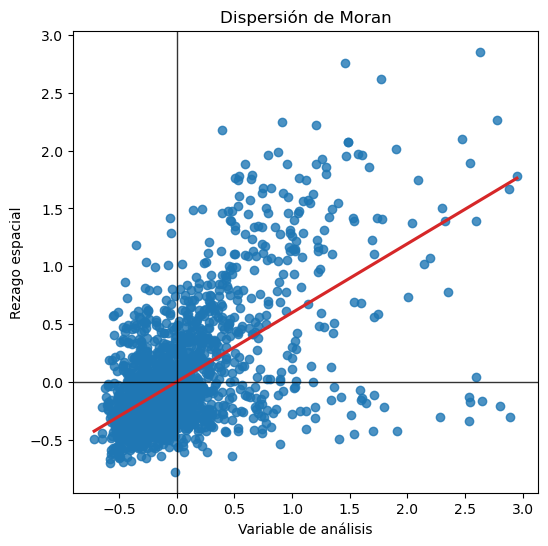

In [11]:
# Especificaciones de figura
fig, ax = plt.subplots(1, figsize=(6,6))

# Elementos de visualización
sns.regplot(
    data=NY_Tracts_Agg_filtered
    ,x='price_scaled'
    ,y='price_lag_scaled'
    ,ci=None
    ,line_kws=dict(color='tab:red')
    ,ax=ax)
ax.axvline(0, color='black', linewidth=1, alpha=0.8)
ax.axhline(0, color='black', linewidth=1, alpha=0.8)


# Anotaciones y estilo
ax.set(
    title='Dispersión de Moran'
    ,xlabel='Variable de análisis'
    ,ylabel='Rezago espacial')

plt.show()

Se debe destacar el significado de los **cuatro cuadrantes** que aparecen en la dispersión de Moran:

* Los cuadrantes **superior derecho** e **inferior izquierdo** corresponden a autocorrelación espacial **positiva**, lo cual significa que estos datos son **similares a sus vecinos**.
* Los cuadrantes **superior izquierdo** e **inferior derecho** corresponder a autocorrelación espacial **negativa**, lo cual significa que en estos datos hay **valores alternantes** con sus vecinos lo cual puede ser indicativo de **outliers** en la región.

Si consideras que en la dispersión de Moran se muestra la **distancia en desviaciones estándar de la media** de los datos, entonces puedes inferir lo siguiente:

* Los puntos en el cuadrante **superior derecho** son _clusters_ por encima de la media, por lo que corresponden a **Hot Spots**.
* Los puntos en el cuadrante **inferior izquierdo** son _clusters_ por debajo de la media, por lo que corresponden a **Cold Spots**.
* Los puntos en el cuadrante **superior izquierdo** son observaciones con **alternancia negativa** con respecto a sus vecinos, es decir, son más chicos que sus vecinos
* Los puntos en el cuadrante **inferior derecho** son observaciones con **alternancia positiva** con respecto a sus vecinos, es decir, son más grandes que sus vecinos

### Significancia estadística

Como se mencionó en la sección anterior, la señal del estadístico _Moran's I_ no es indicativa de nada si no es estadísticamente significativa. Para determinar esto, se utiliza el **p-value** asociado a la prueba de hipótesis. Recordando que las hipótesis son:

* $H_0$: Los datos se distribuyen bajo aleatoriedad espacial.
* $H_1$: Los datos presentan estructura espacial.

Entonces, un mecanismo que puede utilizarse para probar esto es mediante **permutaciones** de los datos. Dado que la $H_0$ plantea que los datos se generan bajo S.R, entonces las permutaciones **reasignan aleatoriamente la variable** de estudio a las distintas observaciones **un número grande de veces**, y para cada permutación se calcula el estadístico _Moran's I_. Finalmente, una vez que se han realizado todas las permutaciones, se genera la **distribución de muestreo** (distribución de referencia) para el estadístico y se determina el **p-value**.

El valor-p indica la probabilidad de observar los datos bajo la distribución de muestreo del estimador, por lo que si la probabilidad es muy baja entonces muy posiblemente exista estructura espacial en los datos, con lo cual el estadístico _Moran's I_ es **estadísticamente significativo**.

Su implementación en Python es utilizando el módulo `pysal.explore.esda`, mismo que necesita los datos y la matriz de pesos, pero no es necesario hacer el preprocesamiento referente a la estandarización de los pesos o centrar la variable de estudio a la medio, ya que el módulo lo implemente por defecto:

In [12]:
# Estadístico de Moran I
morans_stat = esda.moran.Moran(
    y=NY_Tracts_Agg_filtered.price
    ,w=w
    ,transformation='R'
    ,permutations=1_000)

Una vez definida la instancia del estadístico _Moran's I_, entonces se puede resumir lo descrito en la teoría hasta este punto utilizando el siguiente panel:

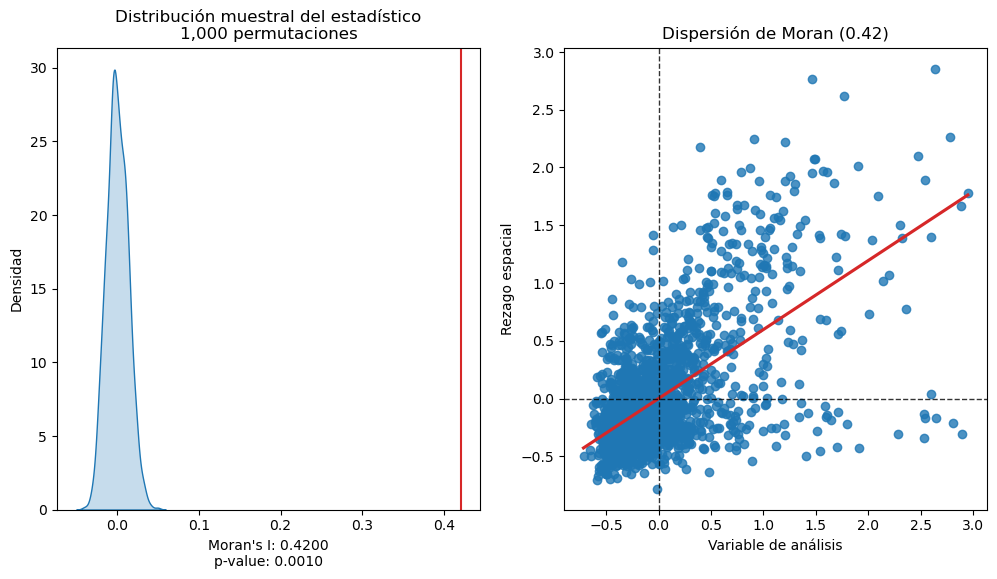

In [13]:
# Especificaciones de figura
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# Elemento de visualización
sns.kdeplot(
    data=morans_stat.sim
    ,fill=True
    ,ax=ax[0])
ax[0].axvline(x=morans_stat.I, color='tab:red')
sns.regplot(
    data=NY_Tracts_Agg_filtered
    ,x='price_scaled'
    ,y='price_lag_scaled'
    ,ci=None
    ,line_kws=dict(color='tab:red')
    ,ax=ax[1])
ax[1].axvline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')
ax[1].axhline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')

# Anotaciones y estilo
ax[0].set(
    title=f'Distribución muestral del estadístico\n{morans_stat.permutations:,} permutaciones'
    ,xlabel=f"Moran's I: {morans_stat.I:.4f}\np-value: {morans_stat.p_sim:.4f}"
    ,ylabel='Densidad')
ax[1].set(
    title=f'Dispersión de Moran ({morans_stat.I:.2f})'
    ,xlabel='Variable de análisis'
    ,ylabel='Rezago espacial')

plt.show()

Al respecto de la significancia estadística, se observa que el estadístico de los datos está extremadamente alejado de la distribución muestral lo cual resulta en un $p_{val}=0.1\%$ con lo cual se asegura que es estadísticamente significativo.

Por otro lado, al observar la dispersión de Moran se puede ver que hay autocorrelación positiva, lo cual da evidencia a favor de la existencia de _clusters_ en los datos con lo cual se rechaza $H_0$ y se acepta $H_1$, es decir, existe algún tipo de estructura espacial en los datos.

## Autocorrelación espacial local

In [14]:
# Estadístico Moran I local
price_lisa = esda.moran.Moran_Local(
    y=NY_Tracts_Agg_filtered.price
    ,w=w
    ,transformation='R'
    ,permutations=1_000
    ,n_jobs=-1)

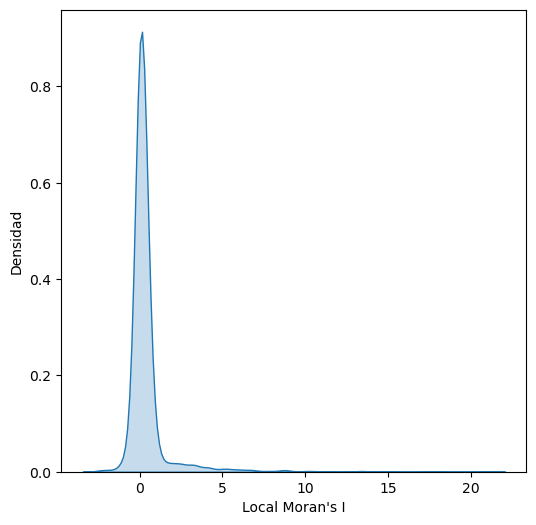

In [15]:
# Especificaciones de figura
fig, ax = plt.subplots(figsize=(6,6))

# Elementos de visualización
sns.kdeplot(
    data=price_lisa.Is
    ,fill=True
    ,ax=ax)

# Anotaciones y estilo
ax.set(
    xlabel="Local Moran's I"
    ,ylabel='Densidad')

plt.show()

In [16]:
# Asignar valores de Moran's Local LISAs a datos originales
NY_Tracts_Agg_filtered = NY_Tracts_Agg_filtered.assign(ML_Is=price_lisa.Is)

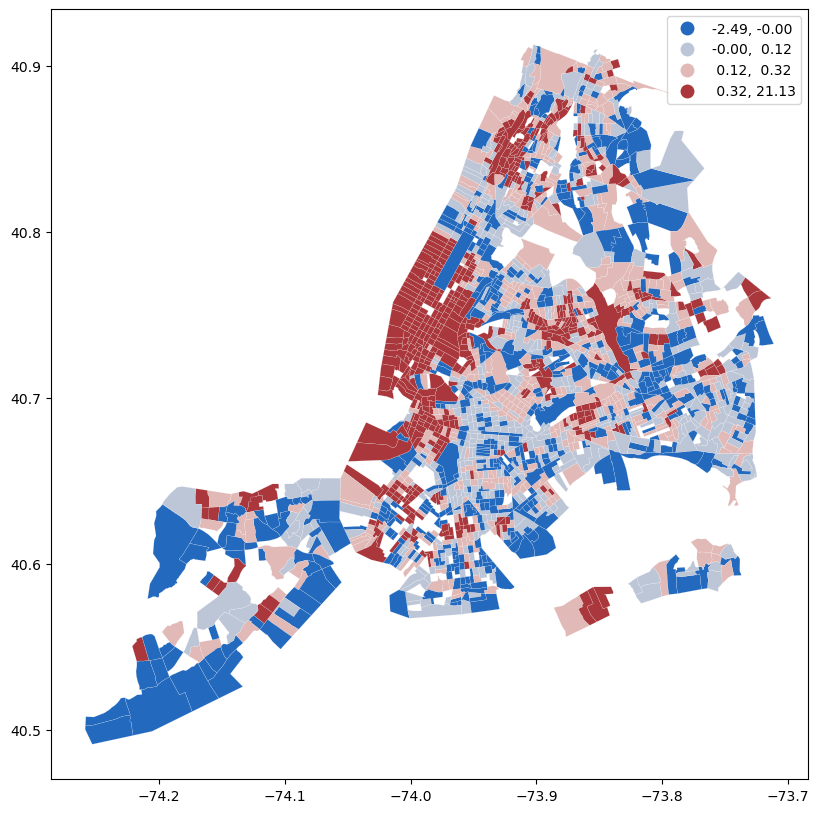

In [18]:
# Especificaciones de figura
fig, ax = plt.subplots(figsize=(10,10))

# Elementos de visualización
NY_Tracts_Agg_filtered.plot(
    column='ML_Is'
    ,cmap='vlag'
    ,scheme='quantiles'
    ,k=4
    ,edgecolor='white'
    ,linewidth=0.1
    ,legend=True
    ,ax=ax)

plt.show()

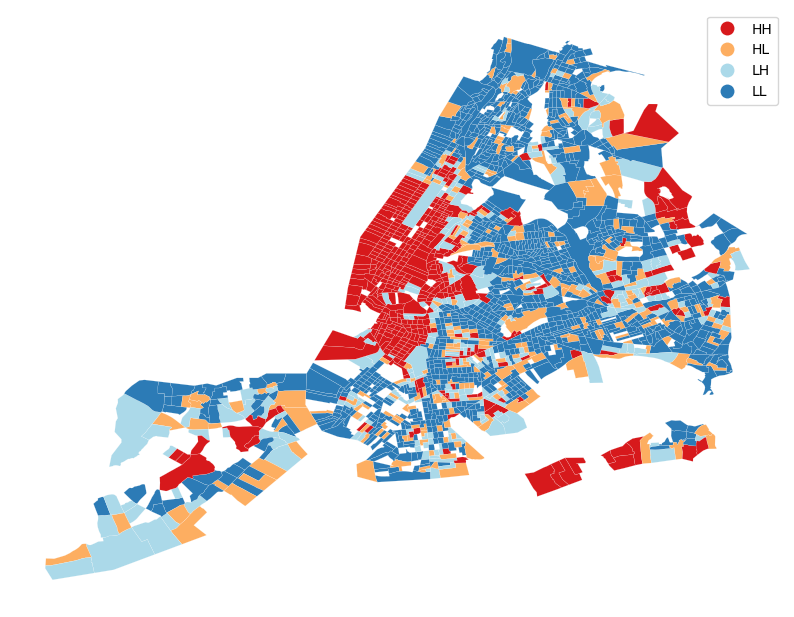

In [26]:
# Especificaciones de figura
fig, ax = plt.subplots(figsize=(10, 10))

# Elementos de visualización
lisa_cluster(
    moran_loc=price_lisa
    ,gdf=NY_Tracts_Agg_filtered
    ,p=1
    ,ax=ax)

plt.show()

In [30]:
# Umbral de significancia
alpha = 0.05

# Indicadora de observaciones significativas
labels = (
    # Serie con máscara de significancia
    pd.Series(
        data=price_lisa.p_sim < alpha,
        index=NY_Tracts_Agg_filtered.index)
    # Asignar etiquetas
    .map({True: 'Significant', False: 'Insignificant'})
)

# Asignar indicadora a datos
NY_Tracts_Agg_filtered = NY_Tracts_Agg_filtered.assign(ML_Sig=pd.Categorical(values=labels))

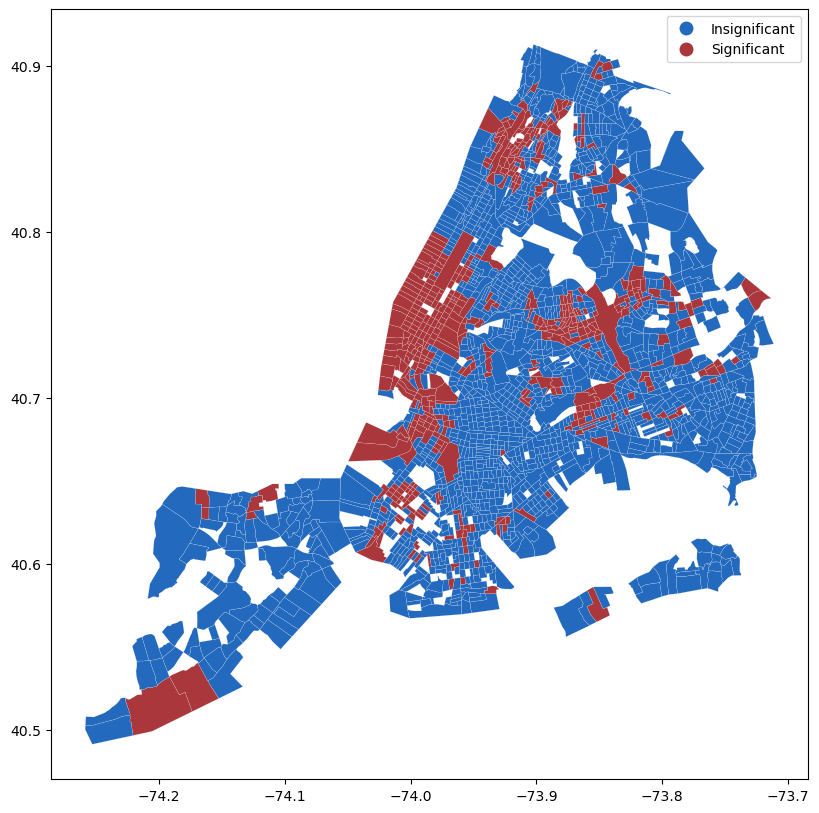

In [35]:
# Especificaciones de figura
fig, ax = plt.subplots(figsize=(10, 10))

# Creating a new column with the labels for significance called ML_Sig
NY_Tracts_Agg_filtered.plot(
    column='ML_Sig'
    ,categorical=True
    ,k=2
    ,cmap='vlag'
    ,linewidth=0.1
    ,edgecolor='white'
    ,legend=True
    ,ax=ax)

plt.show()

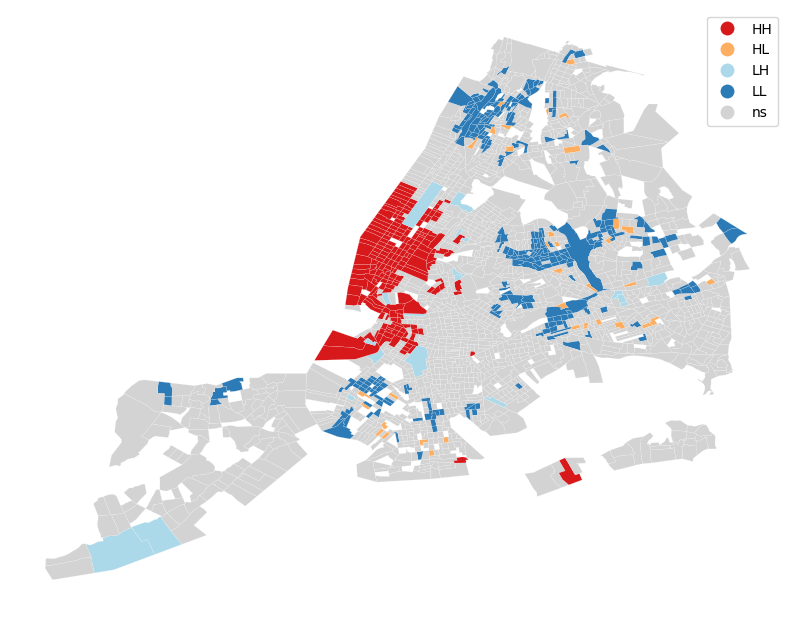

In [36]:
# Especificaciones de figura
fig, ax = plt.subplots(figsize=(10, 10))

# Elementos de visualización
lisa_cluster(
    moran_loc=price_lisa
    ,gdf=NY_Tracts_Agg_filtered
    ,p=alpha
    ,ax=ax)

plt.show()

Otra forma de visualizar LISA's

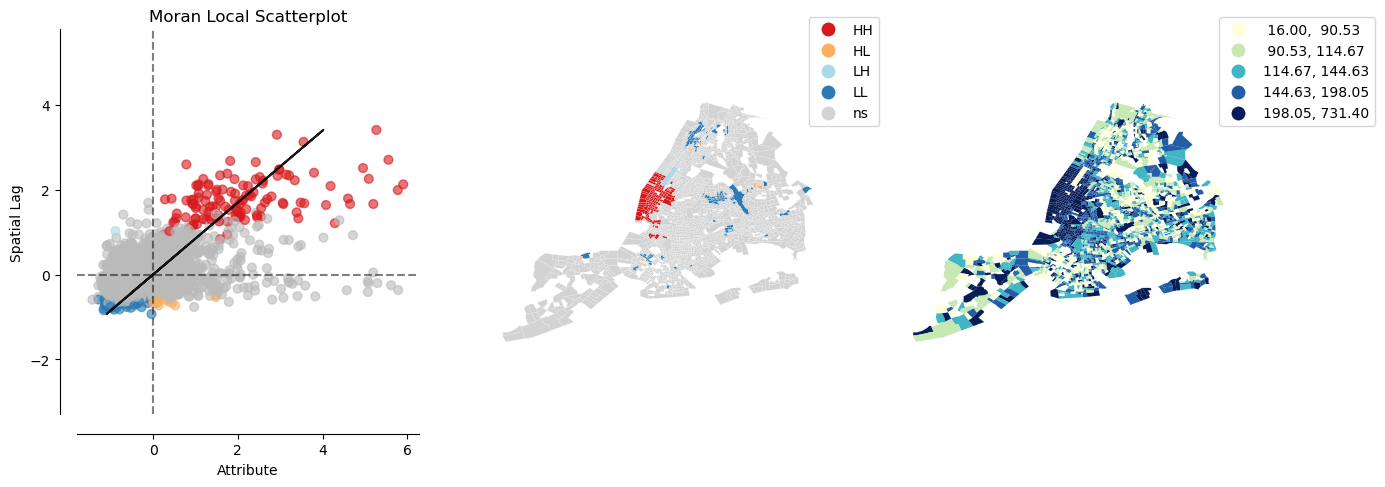

In [45]:
# Elementos de visualización
plot_local_autocorrelation(
    moran_loc=price_lisa
    ,gdf=NY_Tracts_Agg_filtered
    ,attribute='price'
    ,p=0.01
    ,figsize=(15,5))

plt.show()